In [3]:
import numpy as np
from scipy.linalg import eigh
from scipy.sparse.linalg import lobpcg
from scipy.linalg import eigvalsh
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from SALib.sample import morris as morris_sampler
from SALib.analyze import morris as morris_analyzer
from scipy.optimize import minimize
import os
import math
from math import gcd
from functools import partial
from scipy.optimize import minimize

In [582]:
r0          = 1.42   
max_dist    = 2.5   
#first hopping
Vpp_sigma   =  6.4
Vpp_pi      = -2.7
Vsp_sigma   =  6.0
Vss_sigma   = -6.8
beta        =  2.919
#first overlap(considering nonorthorgonal orbitals)
Vss_sigma_overlap = -0.2
Vsp_sigma_overlap = 0.1
Vpp_sigma_overlap = 0.2
Vpp_pi_overlap    = -0.05
beta_overlap = 1.92
Nk          = 500
NUM_BINS    = 300
r_ref       = np.sqrt(3) * r0

unique positions = 32
theoretical number of atom = 32
unique positions = 32
theoretical number of atom = 32


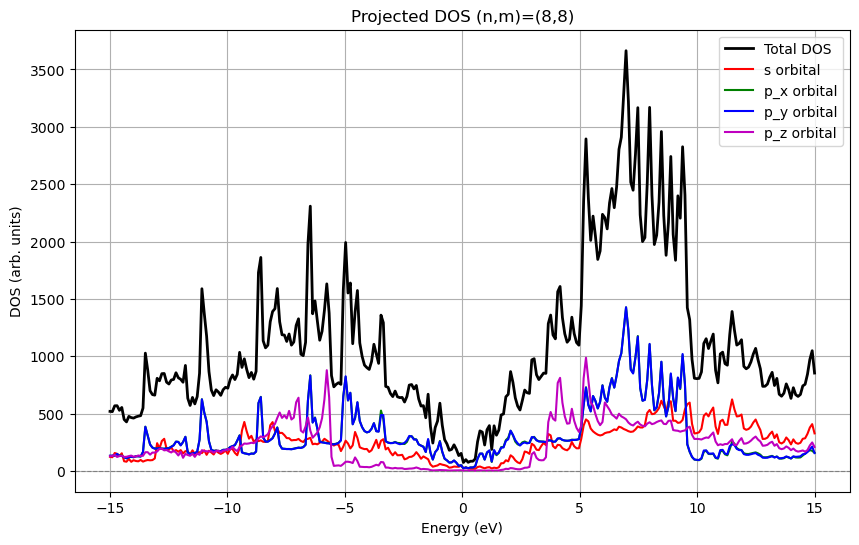

In [ ]:
def compute_Ch(n, m):
    sqrt3 = np.sqrt(3)
    a1 = r0 * np.array([sqrt3/2,  1/2])
    a2 = r0 * np.array([sqrt3/2, -1/2])
    Ch_vec = n * a1 + m * a2  
    
    # gcd 用來決定 T_vec 的週期
    d = gcd(2*n + m, 2*m + n)  
    T1 = (2*m + n) // d
    T2 = -(2*n + m) // d
    T_vec = T1 * a1 + T2 * a2 

    # 4 * (n^2 + n*m + m^2) / d
    N_atom_cell = 4 * (n**2 + m**2 + n*m) // d
    return Ch_vec, T_vec, N_atom_cell, a1, a2

def generate_CNT_lattice(n, m, include_B=True, eps=1e-6):
    Ch_vec, T_vec, N_theoretical, a1, a2 = compute_Ch(n, m)
    M = np.column_stack((Ch_vec, T_vec))
    invM = np.linalg.inv(M)
    
    L = int(np.ceil(np.linalg.norm(Ch_vec)/r0)) + 10
    positions = []

    for t1 in range(-L, L+1):
        for t2 in range(-L, L+1):
            # A
            pos_A = t1 * a1 + t2 * a2
            frac = invM.dot(pos_A)
            if (0 <= frac[0] < 1) and (0 <= frac[1] < 1):
                frac_mod = frac - np.floor(frac)
                frac_mod = np.where(frac_mod >= 1 - eps, 0, frac_mod)
                pos_folded = np.round(M.dot(frac_mod), decimals=6)
                positions.append(pos_folded)
            
            # B
            if include_B:
                pos_B = pos_A + (a1 + a2) / 3
                fracB = invM.dot(pos_B)
                if (0 <= fracB[0] < 1) and (0 <= fracB[1] < 1):
                    fracB_mod = fracB - np.floor(fracB)
                    fracB_mod = np.where(fracB_mod >= 1 - eps, 0, fracB_mod)
                    pos_B_folded = np.round(M.dot(fracB_mod), decimals=6)
                    positions.append(pos_B_folded)
    
    positions = np.array(positions)
    unique_positions = np.unique(positions, axis=0)
    
    assert len(unique_positions) == N_theoretical, "原子數不符理論值"
    print(f'unique positions = {len(unique_positions)}')
    print(f'theoretical number of atom = {N_theoretical}')
    return unique_positions, None, Ch_vec, T_vec

def get_3d_pos(th, z, R):
    x = R * np.cos(th)
    y = R * np.sin(th)
    return x, y, z

def get_3d_vec(i, j, tharr, zarr, R, shift_z=0.0):
    x1, y1, z1 = get_3d_pos(tharr[i], zarr[i], R)
    x2, y2, z2 = get_3d_pos(tharr[j], zarr[j] + shift_z, R)
    return (x2 - x1, y2 - y1, z2 - z1)

def cylindrical_direction(rx, ry, rz):
    r_cyl = np.hypot(rx, ry)
    if r_cyl < 1e-8:
        return 0,0,0,0
    l = rx / r_cyl
    m = ry / r_cyl
    dist = np.sqrt(rx*rx + ry*ry + rz*rz)
    if abs(dist) < 1e-12:
        return 0,0,0, dist
    n = rz / dist
    return l, m, n, dist

def sk_matrix(rx, ry, rz, is_first_nn=True):
    l, m, n, dist = cylindrical_direction(rx, ry, rz)
    if dist < 1e-12:
        return np.zeros((4,4), dtype=complex), np.eye(4)

    vsig = Vpp_sigma * np.exp(-beta * ((dist / r0) - 1))
    vpi  = Vpp_pi   * np.exp(-beta * ((dist / r0) - 1))
    vsp  = Vsp_sigma* np.exp(-beta * ((dist / r0) - 1))
    vss  = Vss_sigma* np.exp(-beta * ((dist / r0) - 1))

    s_vsig = Vpp_sigma_overlap * np.exp(-beta_overlap * ((dist / r0) - 1))
    s_vpi  = Vpp_pi_overlap    * np.exp(-beta_overlap * ((dist / r0) - 1))
    s_vsp  = Vsp_sigma_overlap * np.exp(-beta_overlap * ((dist / r0) - 1))
    s_vss  = Vss_sigma_overlap * np.exp(-beta_overlap * ((dist / r0) - 1))

    H_block = np.zeros((4,4), dtype=complex)
    S_block = np.zeros((4,4), dtype=complex)

    # Hamiltonian entries
    H_block[0,0] = vss
    H_block[0,1] = l * vsp
    H_block[0,2] = m * vsp
    H_block[0,3] = n * vsp
    H_block[1,1] = (l*l)*vsig + (1 - l*l)*vpi
    H_block[2,2] = (m*m)*vsig + (1 - m*m)*vpi
    H_block[3,3] = (n*n)*vsig + (1 - n*n)*vpi
    H_block[1,2] = H_block[2,1] = l*m*(vsig - vpi)
    H_block[1,3] = H_block[3,1] = l*n*(vsig - vpi)
    H_block[2,3] = H_block[3,2] = m*n*(vsig - vpi)

    # Overlap matrix entries
    S_block[0,0] = s_vss
    S_block[0,1] = l * s_vsp
    S_block[0,2] = m * s_vsp
    S_block[0,3] = n * s_vsp
    S_block[1,1] = (l*l)*s_vsig + (1 - l*l)*s_vpi
    S_block[2,2] = (m*m)*s_vsig + (1 - m*m)*s_vpi
    S_block[3,3] = (n*n)*s_vsig + (1 - n*n)*s_vpi
    S_block[1,2] = S_block[2,1] = l*m*(s_vsig - s_vpi)
    S_block[1,3] = S_block[3,1] = l*n*(s_vsig - s_vpi)
    S_block[2,3] = S_block[3,2] = m*n*(s_vsig - s_vpi)

    return H_block, S_block

def build_hamiltonian(n, m):
    coords_2D, subl, Ch_vec, T_vec = generate_CNT_lattice(n, m, True)
    N_cell = len(coords_2D)

    # 圓柱半徑 R, 以及單位胞軸 T_length
    R = (2.46/(2*np.pi)) * math.sqrt(n*n + n*m + m*m)
    T_length = np.linalg.norm(T_vec)

    # 定義方向單位向量
    hatC = Ch_vec / np.linalg.norm(Ch_vec)
    hatT = T_vec / np.linalg.norm(T_vec)

    tharr = []
    zarr  = []
    for rr in coords_2D:
        th = (2*math.pi / np.linalg.norm(Ch_vec)) * (rr.dot(hatC))
        zz = rr.dot(hatT)
        tharr.append(th)
        zarr.append(zz)

    tharr = np.array(tharr)
    zarr  = np.array(zarr)

    # 收集第一近鄰 (同一個超胞內)
    nb_in = []
    for i in range(N_cell):
        for j in range(i+1, N_cell):
            rx, ry, rz = get_3d_vec(i, j, tharr, zarr, R)
            dd = np.sqrt(rx**2 + ry**2 + rz**2)
            if dd < max_dist:
                nb_in.append((i, j))

    # 收集第一近鄰 (跨超胞)
    nb_int = []
    for i in range(N_cell):
        for j in range(N_cell):
            rx, ry, rz = get_3d_vec(i, j, tharr, zarr, R, shift_z=T_length)
            dd = np.sqrt(rx**2 + ry**2 + rz**2)
            if dd < max_dist:
                nb_int.append((i, j, T_length))

    def place_block(H, S, i4, j4, subH, subS):
        H[i4:i4+4, j4:j4+4] += subH
        H[j4:j4+4, i4:i4+4] += subH.T
        S[i4:i4+4, j4:j4+4] += subS
        S[j4:j4+4, i4:i4+4] += subS.T

    def H_of_k(kpar):
        Hdim = 4 * N_cell
        Sdim = 4 * N_cell
        H = np.zeros((Hdim, Hdim), dtype=complex)
        S = np.zeros((Sdim, Sdim), dtype=complex)

        # 同胞內第一近鄰
        for (i, j) in nb_in:
            rx, ry, rz = get_3d_vec(i, j, tharr, zarr, R, shift_z=0.0)
            Hblock, Sblock = sk_matrix(rx, ry, rz, is_first_nn=True)
            i4, j4 = 4*i, 4*j
            place_block(H, S, i4, j4, Hblock, Sblock)

        # 跨胞第一近鄰 
        for (i, j, dz) in nb_int:
            rx, ry, rz = get_3d_vec(i, j, tharr, zarr, R, shift_z=dz)
            Hblock, Sblock = sk_matrix(rx, ry, rz, is_first_nn=True)
            phase = np.exp(1j * kpar * dz)
            i4, j4 = 4*i, 4*j
            H[i4:i4+4, j4:j4+4]       += Hblock * phase
            H[j4:j4+4, i4:i4+4]       += Hblock.conj().T * phase.conj()
            S[i4:i4+4, j4:j4+4]       += Sblock * phase
            S[j4:j4+4, i4:i4+4]       += Sblock.conj().T * phase.conj()
        return H, S

    info = {
        'theta_list': tharr,
        'z_list': zarr,
        'R': R,
        'T_length': T_length,
        'N_cell': N_cell,
        'Ch_vec': Ch_vec
    }
    return H_of_k, info

def solve_with_lowdin(H, S):
    eigvals_s, U = np.linalg.eigh(S)
    min_eig_s = np.min(eigvals_s)

    if min_eig_s < 1e-5:
        regularization = max(1e-5 - min_eig_s, 0.0)
        S_reg = S + regularization * np.eye(S.shape[0])
        eigvals_s, U = np.linalg.eigh(S_reg)

    Lambda_inv_sqrt = np.diag(1.0 / np.sqrt(eigvals_s))
    S_inv_sqrt = U @ Lambda_inv_sqrt @ U.conj().T
    H_ortho = S_inv_sqrt @ H @ S_inv_sqrt
    eigvals_h, eigvecs_h = np.linalg.eigh(H_ortho)
    return eigvals_h, eigvecs_h

def compute_band_structure(builder, TL, Nk):
    k_vals = np.linspace(-np.pi / TL, np.pi / TL, Nk)
    Hk0, Sk0 = builder(0)
    dim = Hk0.shape[0]
    Ek = np.zeros((Nk, dim), dtype=float)

    conduction_band_min = float('inf')
    valence_band_max = float('-inf')

    for i, k in enumerate(k_vals):
        Hk, Sk = builder(k)

        eigvals_s = np.linalg.eigvalsh(Sk)
        min_S = np.min(eigvals_s)
        if min_S < 1e-5:
            offset = 1e-5 - min_S
            Sk = Sk + np.eye(dim) * offset

        eigvals, _ = solve_with_lowdin(Hk, Sk)
        Ek[i, :] = eigvals
        cond_vals = eigvals[eigvals > 0]
        val_vals  = eigvals[eigvals < 0]
        if len(cond_vals) > 0:
            c_local_min = np.min(cond_vals)
            if c_local_min < conduction_band_min:
                conduction_band_min = c_local_min
        if len(val_vals) > 0:
            v_local_max = np.max(val_vals)
            if v_local_max > valence_band_max:
                valence_band_max = v_local_max

    if conduction_band_min == float('inf') or valence_band_max == float('-inf'):
        gap = 0.0
    else:
        gap = conduction_band_min - valence_band_max

    return k_vals, Ek, gap

def compute_DOS(Hbuilder, TL, Nk, Nb=300):
    k_vals = np.linspace(-np.pi / TL, np.pi / TL, Nk)
    all_eigvals = []
    for k_par in k_vals:
        Hk, Sk = Hbuilder(k_par)
        eigvals_s = np.linalg.eigvalsh(Sk)
        min_S = np.min(eigvals_s)
        if min_S < 1e-2:
            offset = 1e-2 - min_S
            Sk += np.eye(Sk.shape[0]) * offset

        eigvals, _ = solve_with_lowdin(Hk, Sk)
        all_eigvals.extend(eigvals)

    all_eigvals = np.array(all_eigvals)
    E_min, E_max = -15, 15
    energy_grid = np.linspace(E_min, E_max, Nb)
    dos = np.zeros_like(energy_grid)
    BROADENING = 0.05
    for E in all_eigvals:
        gf = np.exp(-0.5 * ((energy_grid - E) / BROADENING) ** 2)
        gf /= (BROADENING * np.sqrt(2 * np.pi))
        dos += gf
    return energy_grid, dos


def compute_DOS_with_projection(Hbuilder, TL, Nk, Nb=300):
    k_vals = np.linspace(-np.pi / TL, np.pi / TL, Nk)
    builder, info = build_hamiltonian(n, m)
    N_cell = info['N_cell']
    eigenvalues = []
    orbital_weights = []  
    for k_par in k_vals:
        Hk, Sk = Hbuilder(k_par)
        eigvals_s = np.linalg.eigvalsh(Sk)
        min_S = np.min(eigvals_s)
        if min_S < 1e-5:
            offset = 1e-5 - min_S
            Sk = Sk + np.eye(Sk.shape[0]) * offset
        # 解廣義特徵值問題
        eigvals, eigvecs = solve_with_lowdin(Hk, Sk)

        # 逐條能帶計算軌域投影
        for iband, E in enumerate(eigvals):
            psi = eigvecs[:, iband]  # 取對應的本徵向量
            dim = psi.shape[0]
            # dim = 4 * N_cell
            # 每 4 個元素對應 1 個原子的 [s, px, py, pz]
            w_s = 0.0
            w_px = 0.0
            w_py = 0.0
            w_pz = 0.0

            for iatom in range(N_cell):
                base = iatom * 4
                c_s  = psi[base + 0]
                c_px = psi[base + 1]
                c_py = psi[base + 2]
                c_pz = psi[base + 3]
                w_s  += np.abs(c_s)**2
                w_px += np.abs(c_px)**2
                w_py += np.abs(c_py)**2
                w_pz += np.abs(c_pz)**2

            eigenvalues.append(E)
            orbital_weights.append([w_s, w_px, w_py, w_pz])

    # 轉為 numpy array 方便後續處理
    eigenvalues = np.array(eigenvalues)
    orbital_weights = np.array(orbital_weights)
     
    # 設定能量範圍 & 建立 DOS 格點
    E_min, E_max = -15, 15
    energy_grid = np.linspace(E_min, E_max, Nb)
    BROADENING = 0.05
    
    # 分別累積 s, px, py, pz 的 Gaussian
    s_dos  = np.zeros_like(energy_grid)
    px_dos = np.zeros_like(energy_grid)
    py_dos = np.zeros_like(energy_grid)
    pz_dos = np.zeros_like(energy_grid)

    for iband, E in enumerate(eigenvalues):
        w_s, w_px, w_py, w_pz = orbital_weights[iband]
        # 高斯函式
        gf = np.exp(-0.5 * ((energy_grid - E)/BROADENING)**2)
        gf /= (BROADENING * np.sqrt(2.0 * np.pi))

        s_dos  += w_s  * gf
        px_dos += w_px * gf
        py_dos += w_py * gf
        pz_dos += w_pz * gf

    total_dos = s_dos + px_dos + py_dos + pz_dos
    return energy_grid, s_dos, px_dos, py_dos, pz_dos, total_dos

def save_plot(directory, filename):
    base_path = "C:/Users/user/Desktop/專題/result"
    full_directory = os.path.join(base_path, directory)
    os.makedirs(full_directory, exist_ok=True)
    count = 1
    filepath = os.path.join(full_directory, f"{filename}_{count}.png")
    while os.path.exists(filepath):
        count += 1
        filepath = os.path.join(full_directory, f"{filename}_{count}.png")
    plt.savefig(filepath)
    return filepath

def plot_band_structure(kv, Ek, n, m, dia, Nc, TL):
    plt.figure(figsize=(10, 6))
    num_bands = Ek.shape[1]
    max_band_plot = num_bands  
    for i in range(max_band_plot):
        plt.plot(kv, Ek[:, i], 'b-', linewidth=0.8)

    conduction_band_min = np.min(Ek[Ek > 0]) if np.any(Ek > 0) else None
    valence_band_max    = np.max(Ek[Ek < 0]) if np.any(Ek < 0) else None
    if conduction_band_min is not None and valence_band_max is not None:
        gap = conduction_band_min - valence_band_max
    else:
        gap = 0.0

    plt.title(f"Band Structure (n,m)=({n},{m})  D={dia:.2f} Å  β={beta}")
    plt.xlabel("k (1/Å)")
    plt.ylabel("Energy (eV)")
    plt.axhline(0, color='k', ls='--', lw=0.5)
    plt.grid(True)

    # -pi/T ~ pi/T
    X_val = np.pi / TL
    plt.xticks([-X_val, 0, X_val], ["-X", r"$\Gamma$", "X"])
    plt.ylim(-7, 7)

    filepath = save_plot("band_structures", f"band_structure_{n}_{m}")
    plt.show()
    print(f"Computed Band Gap (global) : {gap:.6f} eV")
    return filepath

def plot_pdos(energy_grid, s_dos, px_dos, py_dos, pz_dos, total_dos, n, m):
    plt.figure(figsize=(10, 6))
    plt.plot(energy_grid, total_dos, label='Total DOS', color='k', linewidth=2)
    plt.plot(energy_grid, s_dos,      label='s orbital', color='r')
    plt.plot(energy_grid, px_dos,     label='p_x orbital', color='g')
    plt.plot(energy_grid, py_dos,     label='p_y orbital', color='b')
    plt.plot(energy_grid, pz_dos,     label='p_z orbital', color='m')

    plt.title(f"Projected DOS (n,m)=({n},{m})")
    plt.xlabel("Energy (eV)")
    plt.ylabel("DOS (arb. units)")
    plt.axhline(0, color='gray', ls='--', lw=0.8)
    plt.legend()
    plt.grid(True)

    filepath = save_plot("pdos", f"pdos_{n}_{m}")
    plt.show()
    return filepath

def simulate_CNT(n, m, plot_type=None, show_plot=True):
    builder, info = build_hamiltonian(n, m)
    Nc = info['N_cell']
    TL = info['T_length']
    Ch_vec = info['Ch_vec']
    R = info['R']
    dia = 2*R

    if plot_type == 'band':
        kv, Ek, gap = compute_band_structure(builder, TL, Nk)
        if show_plot:
            filepath = plot_band_structure(kv, Ek, n, m, dia, Nc, TL)
        else:
            filepath = None
        return {'k_vals': kv, 'E_k': Ek, 'gap_min': gap, 'saved_path': filepath}
    
    elif plot_type == 'pdos':
        eng, s_dos, px_dos, py_dos, pz_dos, total_dos = compute_DOS_with_projection(builder, TL, Nk, Nb=300)
        if show_plot:
            filepath = plot_pdos(eng, s_dos, px_dos, py_dos, pz_dos, total_dos, n, m)
        else:
            filepath = None
        return {'energy grid': eng, 's dos': s_dos, 'px_dos': px_dos,'py_dos':py_dos,'pz_dos':pz_dos, 'total dos':total_dos,'saved_path': filepath}

    else:
        print(f"(n,m)=({n},{m}), diameter={dia:.2f} Å")
        return {'n': n, 'm': m, 'dia': dia, 'N_cell': Nc}
    
if __name__ == "__main__":
    n, m = 8, 8
    result = simulate_CNT(n, m, plot_type='pdos', show_plot=True)

In [373]:
problem = {
    'num_vars': 2,
    'names': ['beta', 'beta_overlap'],
    'bounds': [[2.0, 5.0],
               [2.0, 5.0],]
}

def model_gap(X):
    Y = np.zeros(X.shape[0])
    n, m = 8, 8  
    global beta, beta_overlap
    for i, params in enumerate(X):
        beta,beta_overlap = params
        result = simulate_CNT(n, m, plot_type='band', show_plot=False)
        Y[i] = result.get('gap_min', 0.0)
    return Y

# 生成採樣點
num_trajectories = 20
param_values = morris_sampler.sample(problem, N=num_trajectories, num_levels=2, optimal_trajectories=2)
Y = model_gap(param_values)

# morris analyze
Si = morris_analyzer.analyze(problem, param_values, Y, num_levels=2, print_to_console=True)
mu_star_array = np.array(Si['mu_star'])
sigma_array   = np.array(Si['sigma'])

param_names = ['beta', 'beta_2', 'beta_overlap', 'beta2_overlap']
x = np.arange(len(param_names))  # parameter position
bar_width = 0.35

fig, ax = plt.subplots(figsize=(8,6))

bars1 = ax.bar(x - bar_width/2, mu_star_array, bar_width, label='mu*', color='skyblue')
bars2 = ax.bar(x + bar_width/2, sigma_array, bar_width, label='sigma', color='salmon')

ax.set_ylabel('Value')
ax.set_title('Morris Analysis Results')
ax.set_xticks(x)
ax.set_xticklabels(param_names)
ax.legend()

def autolabel(rects, fmt="{:.3f}"):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(fmt.format(height),
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)
plt.tight_layout()
filepath = save_plot("Morris Analysis Result", f"Morris Analysis Result")
plt.show()

unique positions = 32
theoretical number of atom = 32


KeyboardInterrupt: 

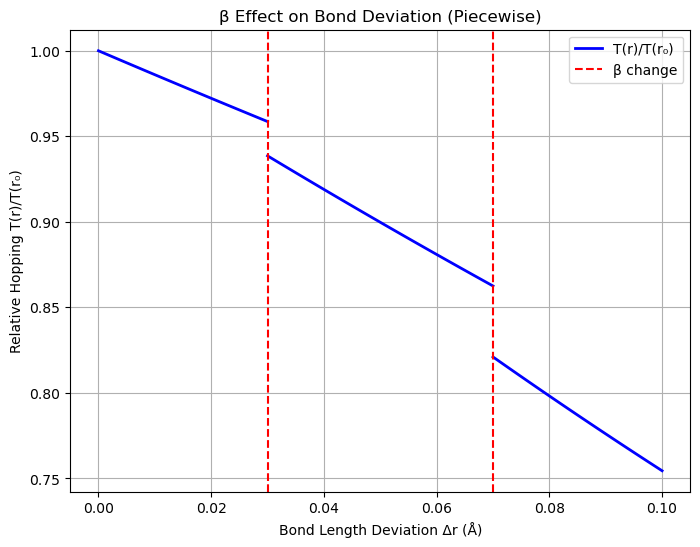

In [8]:
r0 = 1.42

# 定義三個區段的 Δr 範圍
delta_r1 = np.linspace(0.00, 0.03, 50)
delta_r2 = np.linspace(0.03, 0.07, 50)
delta_r3 = np.linspace(0.07, 0.10, 50)

# 對應三段的 β 值
beta1 = 2
beta2 = 3
beta3 = 4

# 計算各區段的相對躍遷積分
f1 = np.exp(-beta1 * (delta_r1 / r0))
f2 = np.exp(-beta2 * (delta_r2 / r0))
f3 = np.exp(-beta3 * (delta_r3 / r0))

plt.figure(figsize=(8,6))

# 先畫第一段
plt.plot(delta_r1, f1, 'b-', linewidth=2)

# 接續第二段（在 0.03 Å 處能銜接上）
plt.plot(delta_r2, f2, 'b-', linewidth=2)

# 接續第三段
plt.plot(delta_r3, f3, 'b-', linewidth=2, label="T(r)/T(r₀)")

# 垂直線標示 β 改變位置
plt.axvline(0.03, color='r', linestyle='--', linewidth=1.5, label="β change")
plt.axvline(0.07, color='r', linestyle='--', linewidth=1.5)

plt.xlabel("Bond Length Deviation Δr (Å)")
plt.ylabel("Relative Hopping T(r)/T(r₀)")
plt.title("β Effect on Bond Deviation (Piecewise)")
plt.grid(True)
plt.legend()
save_plot('β Effect on Bond Deviation','β Effect on Bond Deviation')
plt.show()